# Irish forestry coverage

Links:

* https://www.thejournal.ie/coillte-to-redesign-nine-dublin-forests-for-recreational-uses-and-to-support-biodiversity-4691679-Jun2019/

In [1]:
import pandas as pd
import geopandas as gpd
import json
import matplotlib as mpl
import pylab as plt

from bokeh.io import output_file, show, output_notebook, export_png
from bokeh.models import ColumnDataSource, GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool, DataRange1d
from bokeh.tile_providers import get_provider, Vendors
from bokeh.plotting import figure
from bokeh.palettes import brewer

#import panel as pn
#import panel.widgets as pnw
#pn.extension()
output_notebook()

/usr/local/lib/python3.10/dist-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


Loading BokehJS ...

In [2]:
def get_geodatasource(gdf):    
    """Get getjsondatasource from geopandas object"""
    json_data = json.dumps(json.loads(gdf.to_json()))
    return GeoJSONDataSource(geojson = json_data)

In [3]:
counties = gpd.read_file('data/counties.shp')
counties=counties.to_crs("EPSG:3857")
counties['total_area'] = counties['geometry'].to_crs('EPSG:6933').geometry.area/10**6

In [4]:
forests = gpd.read_file('forestry_data/landuse_forests.shp')
forests = forests.to_crs("EPSG:3857")
forests['type'] = 'plantation'

In [5]:
woods = gpd.read_file('forestry_data/natural_wood.shp')
woods = woods.to_crs("EPSG:3857")
woods['type'] = 'wood'

In [6]:
forests['area'] = forests.to_crs('EPSG:6933').geometry.area/10**6

In [7]:
woods['area'] = woods.to_crs('EPSG:6933').geometry.area/10**6

In [8]:
leabound = gpd.read_file('forestry_data/2019_LEA_Boundaries.shp')
leabound = leabound.to_crs("EPSG:3857")

In [9]:
a = pd.concat([forests,woods])

In [10]:
coverage = a.groupby('county').agg({'area':sum}).reset_index().rename(columns={'area':'coverage'})
counties = counties.merge(coverage,left_on='NAME_TAG',right_on='county')
counties['perc_coverage'] = counties.coverage/counties.total_area

In [ ]:
counties[['county','total_area','coverage','perc_coverage']].sort_values('perc_coverage',ascending=False)

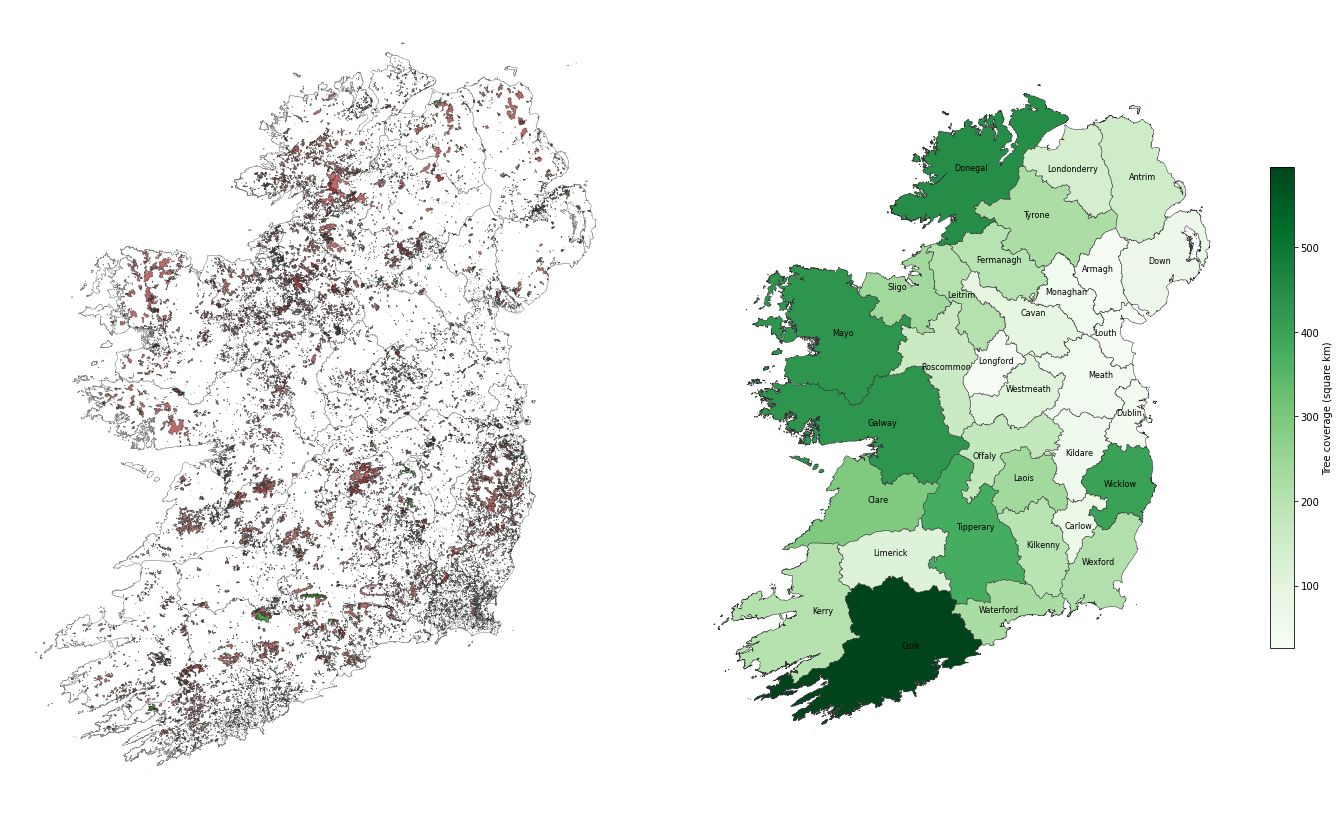

In [12]:
fig, axs = plt.subplots(1,2, figsize=(20,12))
axs=axs.flat
x = forests.sample(5000)
counties.plot(edgecolor='0.5',linewidth=0.5,color='white',ax=axs[0])
forests.plot(edgecolor='0.2',linewidth=.5,alpha=0.7,color='brown',ax=axs[0])
woods.plot(edgecolor='0.2',linewidth=.5,alpha=0.7,color='green',ax=axs[0])
counties.plot(column='coverage',edgecolor='0.2',linewidth=.5,cmap='Greens',
              legend=True,legend_kwds={'label': "Tree coverage (square km)", "shrink": .6}, ax=axs[1])

counties['coords'] = counties['geometry'].apply(lambda x: x.representative_point().coords[:][0])
for idx, row in counties.iterrows():
    plt.annotate(text=row['NAME_TAG'], xy=row['coords'],
                 horizontalalignment='center', fontsize=8)
plt.tight_layout()
axs[0].set_axis_off()
axs[1].set_axis_off()
fig.savefig('ireland_forestry_cover.png',dpi=200)

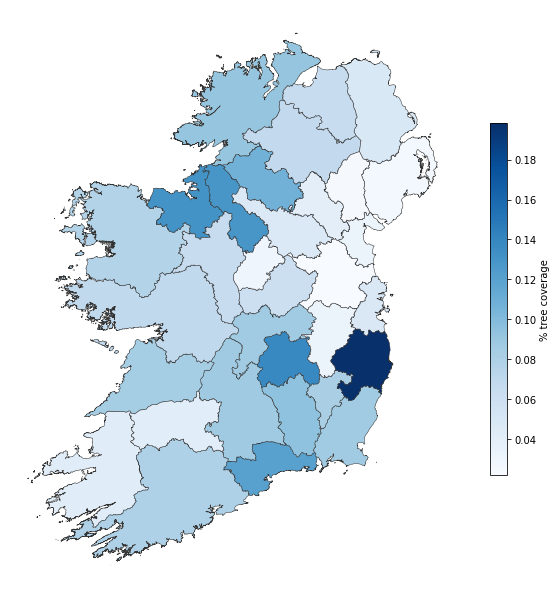

In [13]:
fig, ax = plt.subplots(1,1, figsize=(9,9))
counties.plot(column='perc_coverage',edgecolor='0.2',linewidth=.5,cmap='Blues',
              legend=True,legend_kwds={'label': "% tree coverage", "shrink": .6}, ax=ax)
plt.tight_layout()
ax.set_axis_off()
fig.savefig('ireland_forestry_percent_cover.png',dpi=150)

In [ ]:
import numpy as np
from shapely.geometry import Point
xmin, xmax, ymin, ymax = 900000, 1080000, 120000, 280000
xc = (xmax - xmin) * np.random.random(2000) + xmin
yc = (ymax - ymin) * np.random.random(2000) + ymin
pts = GeoSeries([Point(x, y) for x, y in zip(xc, yc)])
circles = pts.buffer(2000)
mp = circles.unary_union
holes = boros['geometry'].intersection(mp)


## wicklow

In [14]:
wicklow = a[a.county.isin(['Wicklow'])]

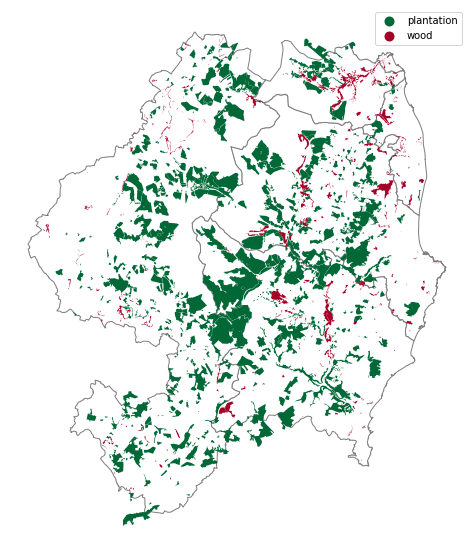

In [19]:
def plot_area(df, borders):
    fig, ax = plt.subplots(1,1, figsize=(12,10))
    borders.plot(ax=ax,color='white',edgecolor='0.5')
    df.plot(column='type',cmap='RdYlGn_r',ax=ax,legend=True)
    ax.set_axis_off()    
plot_area(wicklow,leabound)
fig.savefig('wicklow_forestry_cover.png',dpi=150)

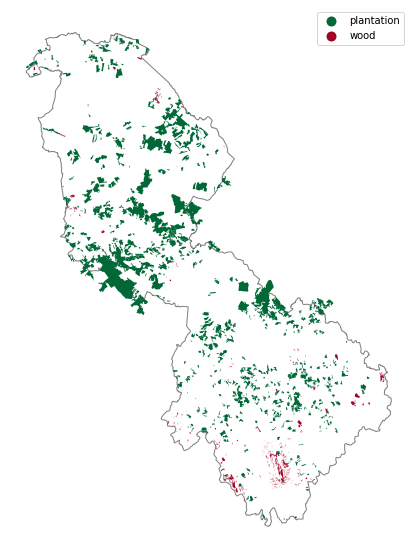

In [20]:
x = a[a.county.isin(['Leitrim'])]
b=counties[counties.county=='Leitrim']
plot_area(x,b)

## bokeh plot

In [1]:
def bokeh_plot_map(geosources, colors, columns=None, title='', plot_width=500):
    """Plot bokeh map from GeoJSONDataSources """
    
    palette = brewer['OrRd'][8]
    palette = palette[::-1]    
    tools = 'wheel_zoom,pan,box_zoom,reset'
    h=int(plot_width*1.4)
    #minx, miny, maxx, maxy = counties.total_bounds
    #xr = DataRange1d(minx, maxx)
    #yr = DataRange1d(miny, maxy)
    p = figure(title = title, plot_height=h , plot_width=plot_width, #x_range=xr, y_range=yr,
               toolbar_location='right', tools=tools)
    i=0    
    for src in geosources:
        l=p.patches('xs','ys', source=src, fill_alpha=1, line_width=1.5, line_color='black', 
                    line_alpha=0.6, fill_color=colors[i])
        if columns == None:
            continue
        cols = columns[i]
        if cols != None:
            x = [(i, "@%s" %i) for i in cols]    
            hover = HoverTool(tooltips=x, point_policy='follow_mouse', renderers=[l])        
            #l.hover.tooltips = hover
            p.add_tools(hover)
        i+=1
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.match_aspect = True
    #BoxZoomTool.match_aspect = True    
    p.toolbar.logo = None
    return p

In [2]:
gsrc1 = get_geodatasource(counties)
gsrc2 = get_geodatasource(gsi)
gsrc3 = get_geodatasource(forests)
p = bokeh_plot_map([gsrc1,gsrc2,gsrc3], colors=['whitesmoke','brown','#99cc00'], columns=[None,['SITENAME','DESCRIPT'],['name']])
pn.pane.Bokeh(p)

NameError: name 'get_geodatasource' is not defined